In [36]:
############################ 0. PREPARATION ############################

#-------------------------- import packages --------------------------
import random
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from itertools import combinations
import seaborn as sns
import copy
import itertools

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Multiply, Add, Embedding, Reshape, Concatenate, Dropout, BatchNormalization, Lambda, Layer, CategoryEncoding
from keras.constraints import Constraint
from keras.callbacks import EarlyStopping
from keras.initializers import Zeros, Constant
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.models import clone_model
import keras_tuner as kt
from keras import regularizers
from keras.utils import plot_model
from tensorflow.keras.losses import Poisson
from tensorflow.keras.losses import Loss
from keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from keras import backend as K
from scipy.stats import gamma


from pygam import LinearGAM, GAM, s, f, l
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error as mae
from sklearn.tree import DecisionTreeRegressor
from interpret.glassbox import ExplainableBoostingClassifier

In [37]:
#-------------------------- for reproducibility --------------------------
seed_value = 2024
keras.utils.set_random_seed(seed_value)

In [38]:
#-------------------------- import data --------------------------
dt_low = pd.read_csv("synthetic_low_var_old.csv") # low variance of response
dt_high = pd.read_csv("synthetic_high_var_old.csv") # high variance of response
dt_low.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X12,X13,X14,X15,X16,X17,X18,X19,X20,Y
0,1.764052,0.330046,-1.939500,-1.077659,0.571578,-0.483797,1,0,0.548387,0,...,0.301555,-1.113651,1.213172,2.787449,-0.609772,1.500887,-0.204733,0.268551,-0.975570,416.138827
1,0.400157,-0.000480,0.738850,-0.842292,0.890052,1.288057,1,1,-0.127653,1,...,-1.261458,1.181924,-0.612534,0.990208,-1.438862,0.268059,1.504559,-1.140601,-1.033217,115.096070
2,0.978738,0.818116,1.394685,-0.257808,-0.386379,-0.129879,1,2,0.157828,5,...,0.503851,-0.991021,1.575024,-1.165941,-0.219119,-1.077511,-0.468281,-1.050298,-0.397200,9.914496
3,2.240893,0.428214,-0.813585,0.712076,-0.326870,-0.198078,0,0,-1.311055,1,...,-1.650107,0.239825,-0.055773,1.080850,-1.986662,-1.632279,1.375089,-0.949292,2.110361,369.250611
4,1.867558,-2.503947,-0.818822,0.545792,1.169869,-0.334488,1,2,1.162186,6,...,-0.067660,1.375720,-0.336183,0.270723,1.246417,1.206773,-1.907251,1.489624,0.183740,8243.603967


In [39]:
#-------------------------- remove outliers - low variance --------------------------
log_claim = np.log(dt_low['Y'])
IQR = log_claim.quantile(0.75) - log_claim.quantile(0.25) # inter-quartile range
lower_whisker = log_claim.quantile(0.25)- 1.5*IQR
upper_whisker = log_claim.quantile(0.75) + 1.5*IQR

# remove outliers: filter rows where the log of 'Y' is within the whiskers
dt_low_cleaned = dt_low[(log_claim >= lower_whisker) & (log_claim <= upper_whisker)]
dt_low_cleaned

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X12,X13,X14,X15,X16,X17,X18,X19,X20,Y
0,1.764052,0.330046,-1.939500,-1.077659,0.571578,-0.483797,1,0,0.548387,0,...,0.301555,-1.113651,1.213172,2.787449,-0.609772,1.500887,-0.204733,0.268551,-0.975570,416.138827
1,0.400157,-0.000480,0.738850,-0.842292,0.890052,1.288057,1,1,-0.127653,1,...,-1.261458,1.181924,-0.612534,0.990208,-1.438862,0.268059,1.504559,-1.140601,-1.033217,115.096070
2,0.978738,0.818116,1.394685,-0.257808,-0.386379,-0.129879,1,2,0.157828,5,...,0.503851,-0.991021,1.575024,-1.165941,-0.219119,-1.077511,-0.468281,-1.050298,-0.397200,9.914496
3,2.240893,0.428214,-0.813585,0.712076,-0.326870,-0.198078,0,0,-1.311055,1,...,-1.650107,0.239825,-0.055773,1.080850,-1.986662,-1.632279,1.375089,-0.949292,2.110361,369.250611
4,1.867558,-2.503947,-0.818822,0.545792,1.169869,-0.334488,1,2,1.162186,6,...,-0.067660,1.375720,-0.336183,0.270723,1.246417,1.206773,-1.907251,1.489624,0.183740,8243.603967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.271662,-1.457199,-1.392817,1.020770,-0.337715,0.462160,1,9,-2.126894,3,...,-0.022294,-1.483453,-0.812134,-0.968497,1.347094,-0.265738,-0.448003,-2.129819,0.905729,53.391874
19996,-0.108997,2.011115,-0.149613,0.602852,-2.028548,1.549025,2,8,0.443363,4,...,-0.731599,0.218460,0.752832,-0.123577,0.589087,-1.444406,-0.497505,-1.614904,-0.431585,235.070121
19997,-0.057259,1.689858,0.895979,-1.048735,0.726182,2.531705,1,1,1.613782,9,...,-1.285469,-1.239966,-0.951650,-0.369181,-1.545533,-0.254590,-0.237856,-1.261787,-0.105483,636.217328
19998,-1.058931,0.199966,-2.116870,0.374758,-1.167831,-0.035722,1,3,-0.663214,7,...,0.699014,0.752009,-0.940125,0.937294,-1.041598,0.789186,-1.283383,1.261313,0.349082,814.987810


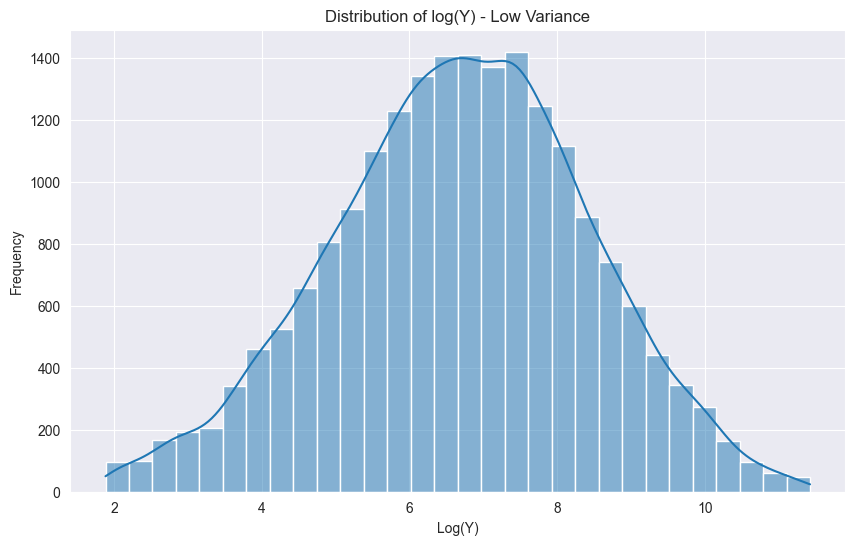

In [40]:
#-------------------------- distribution of log(response) - low variance --------------------------
plt.figure(figsize = (10, 6)) # set the size of the figure
sns.set_style("darkgrid")
sns.histplot(np.log(dt_low_cleaned['Y']), bins = 30, kde = True) # draw the chart
plt.title('Distribution of log(Y) - Low Variance')
plt.xlabel('Log(Y)')
plt.ylabel('Frequency')
plt.tick_params(axis = 'x')
plt.tick_params(axis = 'y')
plt.grid(True)
plt.show()

In [41]:
#-------------------------- remove outliers - high variance --------------------------
log_claim = np.log(dt_high['Y'])
IQR = log_claim.quantile(0.75) - log_claim.quantile(0.25) # inter-quartile range
lower_whisker = log_claim.quantile(0.25)- 1.5*IQR
upper_whisker = log_claim.quantile(0.75) + 1.5*IQR

# remove outliers: filter rows where the log of 'Y' is within the whiskers
dt_high_cleaned = dt_high[(log_claim >= lower_whisker) & (log_claim <= upper_whisker)]
dt_high_cleaned

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X12,X13,X14,X15,X16,X17,X18,X19,X20,Y
0,1.764052,0.330046,-1.939500,-1.077659,0.571578,-0.483797,1,0,0.548387,0,...,0.301555,-1.113651,1.213172,2.787449,-0.609772,1.500887,-0.204733,0.268551,-0.975570,138.791786
1,0.400157,-0.000480,0.738850,-0.842292,0.890052,1.288057,1,1,-0.127653,1,...,-1.261458,1.181924,-0.612534,0.990208,-1.438862,0.268059,1.504559,-1.140601,-1.033217,6009.800551
3,2.240893,0.428214,-0.813585,0.712076,-0.326870,-0.198078,0,0,-1.311055,1,...,-1.650107,0.239825,-0.055773,1.080850,-1.986662,-1.632279,1.375089,-0.949292,2.110361,0.327112
4,1.867558,-2.503947,-0.818822,0.545792,1.169869,-0.334488,1,2,1.162186,6,...,-0.067660,1.375720,-0.336183,0.270723,1.246417,1.206773,-1.907251,1.489624,0.183740,40.337116
5,-0.977278,0.120481,-0.102798,1.260219,0.892693,-0.391443,2,9,-0.012386,3,...,0.387610,-1.837163,-1.028304,-1.316439,-0.732250,-1.060493,1.303541,0.217403,0.947306,0.941318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.271662,-1.457199,-1.392817,1.020770,-0.337715,0.462160,1,9,-2.126894,3,...,-0.022294,-1.483453,-0.812134,-0.968497,1.347094,-0.265738,-0.448003,-2.129819,0.905729,3129.312685
19996,-0.108997,2.011115,-0.149613,0.602852,-2.028548,1.549025,2,8,0.443363,4,...,-0.731599,0.218460,0.752832,-0.123577,0.589087,-1.444406,-0.497505,-1.614904,-0.431585,0.280734
19997,-0.057259,1.689858,0.895979,-1.048735,0.726182,2.531705,1,1,1.613782,9,...,-1.285469,-1.239966,-0.951650,-0.369181,-1.545533,-0.254590,-0.237856,-1.261787,-0.105483,0.295402
19998,-1.058931,0.199966,-2.116870,0.374758,-1.167831,-0.035722,1,3,-0.663214,7,...,0.699014,0.752009,-0.940125,0.937294,-1.041598,0.789186,-1.283383,1.261313,0.349082,497.171281


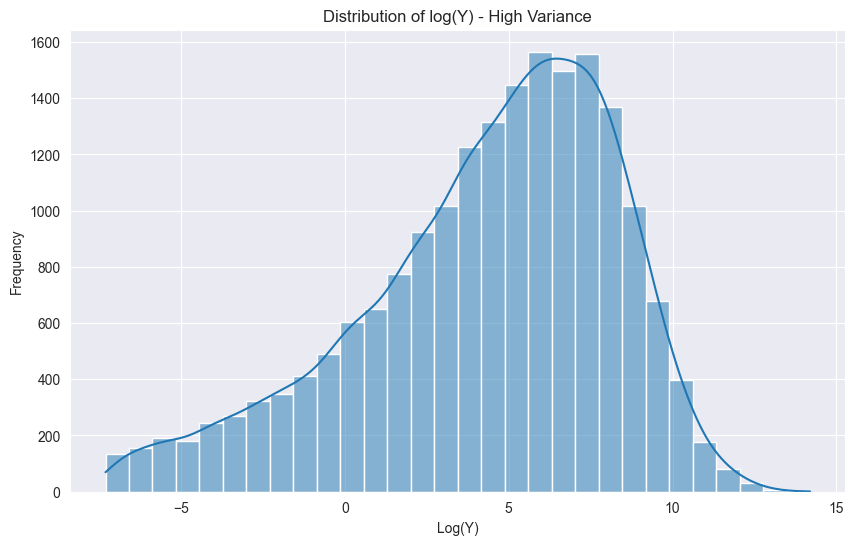

In [42]:
#-------------------------- distribution of log(response) - high variance --------------------------
plt.figure(figsize = (10, 6)) # set the size of the figure
sns.set_style("darkgrid")
sns.histplot(np.log(dt_high_cleaned['Y']), bins = 30, kde = True) # draw the chart
plt.title('Distribution of log(Y) - High Variance')
plt.xlabel('Log(Y)')
plt.ylabel('Frequency')
plt.tick_params(axis = 'x')
plt.tick_params(axis = 'y')
plt.grid(True)
plt.show()

In [43]:
############################ 1. MODEL FITTING ############################

cat_vars = ["X7", "X8", "X10"] # categorical features
all_vars = list(dt_low_cleaned.columns) # all features
all_vars.remove("Y") # remove the target variables

#-------------------------- train-test split --------------------------

# low variance
X_main_low, X_test_low, y_main_low, y_test_low = train_test_split(
    dt_low_cleaned.drop(["Y"], axis = 1), dt_low_cleaned[["Y"]], test_size = 0.2, random_state = 1)
X_train_low, X_val_low, y_train_low, y_val_low = train_test_split(
    X_main_low, y_main_low, test_size = 0.25, random_state = 1)

# high variance
X_main_high , X_test_high , y_main_high , y_test_high  = train_test_split(
    dt_high_cleaned.drop(["Y"], axis = 1), dt_high_cleaned[["Y"]], test_size = 0.2, random_state = 1)
X_train_high , X_val_high , y_train_high , y_val_high  = train_test_split(
    X_main_high , y_main_high , test_size = 0.25, random_state = 1)

### GAMINet approach - Low Variance

In [44]:
# -------------------------- function to create a subnetwork --------------------------
# subnet for numerical variables
def create_subnet(num_layers, units_per_layer, activation, model_name, dropout_rate = 0, trainable = True, seed = 1):
    model = Sequential(name = model_name)
    for _ in range(num_layers):
        model.add(Dense(units_per_layer, activation = activation, trainable = trainable))
        model.add(Dropout(dropout_rate, seed = seed))
    model.add(Dense(1, trainable = trainable))
    model.add(Lambda(lambda x: x - keras.ops.mean(x, axis = 0, keepdims = True), output_shape=(1,))) # zero center all output
    return model

In [45]:
# -------------------------- create a NAM with main effects--------------------------

# model architecture
inputs = []  # Store input layers
sub_outputs = []  # Outputs from each subnet

# model hyperparameters
num_neurons = 10
num_layers = 1
activation = 'leaky_relu'

# main effect
for name in all_vars:

    input_layer = Input(shape = (1,), name = name)
    inputs.append(input_layer)

    if name in cat_vars: # numeric variables
        # categorical variables will be one-hot encoded
        embed_layer = Embedding(input_dim = dt_low_cleaned[name].nunique(), output_dim = 1, name = f"embed_{name}")(input_layer)
        embed_layer_reshape = Reshape(target_shape = (1,))(embed_layer)
        switcher_layer = Dense(1, use_bias = False,
                               kernel_initializer = Constant(1.0), 
                               trainable = False, 
                               name = f"{name}_switcher_layer")(embed_layer_reshape) # used for pruning later
        sub_outputs.append(switcher_layer)
    else:
        subnet = create_subnet(num_layers, num_neurons, activation, f"{name}_subnetwork")
        sub_output = subnet(input_layer)
        switcher_layer = Dense(1, use_bias = False, 
                               kernel_initializer = Constant(1.0), 
                               trainable = False, 
                               name = f"{name}_switcher_layer")(sub_output) # used for pruning later
        sub_outputs.append(switcher_layer)

# combine subnets' outputs
subnets = Concatenate(name = f"subnet_output")(sub_outputs + [])
output_layer = Dense(1, activation = 'exponential', 
                     kernel_initializer = Constant(1),
                     name = "final_output")(subnets)

# final model
model_GAMI_low = Model(inputs = inputs, outputs = output_layer)

# plot_model(model_GAMI, show_layer_names = True, show_shapes = True)

In [46]:
# -------------------------- compile and train the model --------------------------
# we will use a Gamma loss function
def gamma_log_likelihood(y_true, y_pred):
    y_pred = keras.ops.clip(y_pred, 1e-7, 1e30)
    return keras.ops.mean(y_true/y_pred - keras.ops.log(y_true/y_pred))

# create training & validation data consistent with the model architecture
X_train_low_split = []
X_val_low_split = []
for i in range(len(X_train_low.columns)):
    X_train_low_split.append(X_train_low.iloc[:, i])
    X_val_low_split.append(X_val_low.iloc[:, i])

# compile and fit
model_GAMI_low.compile(optimizer = "rmsprop", loss = gamma_log_likelihood, metrics = [RootMeanSquaredError()])
es = EarlyStopping(restore_best_weights = True, patience = 10)
%time hist_main = model_GAMI_low.fit(X_train_low_split, y_train_low, epochs = 5_000, \
    callbacks = [es], batch_size = 500, validation_data = (X_val_low_split, y_val_low))

Epoch 1/5000


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 6380.4585 - root_mean_squared_error: 7671.7617 - val_loss: 3955.6362 - val_root_mean_squared_error: 7707.6938
Epoch 2/5000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3640.1504 - root_mean_squared_error: 7671.7754 - val_loss: 2689.4934 - val_root_mean_squared_error: 7707.6421
Epoch 3/5000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2514.7109 - root_mean_squared_error: 7671.6992 - val_loss: 1894.5913 - val_root_mean_squared_error: 7707.5112
Epoch 4/5000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1781.2178 - root_mean_squared_error: 7671.5361 - val_loss: 1352.6646 - val_root_mean_squared_error: 7707.2798
Epoch 5/5000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1272.8236 - root_mean_squared_error: 7671.2603 - val_loss: 968.8618 - val_root_mean_squared_error: 7706.9111
Epoch 6/5000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 910.4310 - root_mean_squared_error: 7670.8311 - val_loss: 691.2189 - val_root_mean_squared_error: 7706.

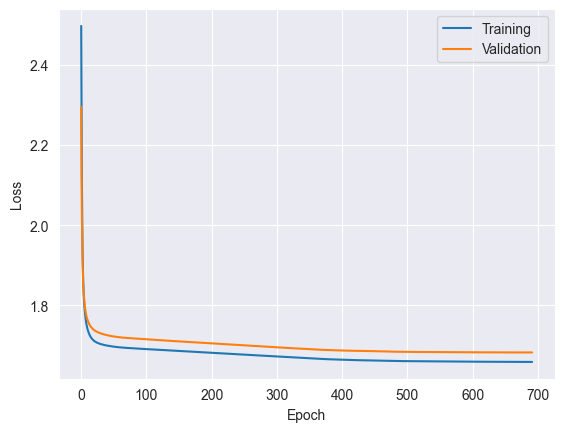

In [47]:
# -------------------------- plot the loss curve --------------------------
plt.plot(hist_main.history["loss"][20:])
plt.plot(hist_main.history["val_loss"][20:])
plt.legend(["Training", "Validation"])
plt.xlabel("Epoch")
plt.ylabel("Loss");

  1/371 ━━━━━━━━━━━━━━━━━━━━ 1:10 191ms/step

371/371 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


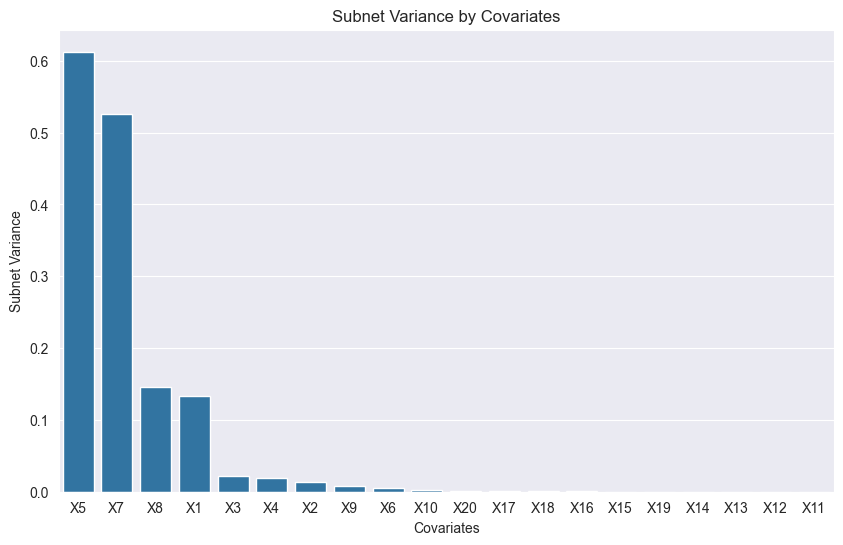

In [48]:
# -------------------------- quantify variable importance --------------------------
# Create a new model to get the output of the 'subnet_output' layer
subnet_output_layer = model_GAMI_low.get_layer("subnet_output")  # Get the subnet output layer
subnet_output_model = Model(inputs = model_GAMI_low.inputs, outputs = subnet_output_layer.output)
subnet_output_values = subnet_output_model.predict(X_train_low_split)
subnet_weights = model_GAMI_low.get_layer("final_output").get_weights()[0]

# Get the variance of each subnetwork across all data points
subnet_variance = []
for i in range(subnet_output_values.shape[1]):
    subnet_variance.append(np.var(subnet_output_values[:, i])*subnet_weights[i][0]**2)

# Define covariates
covariates = [name for name in all_vars]

# -------------------------- plot the variable importance --------------------------
# Create DataFrame for variable importance
var_importance = pd.DataFrame({"Covariates": covariates, "Subnet Variance": subnet_variance})

# Sort the DataFrame by subnet variance in decreasing order
varimp_sorted = var_importance.sort_values(by = "Subnet Variance", ascending = False)

# Create a bar plot using Seaborn
plt.figure(figsize = (10, 6))
sns.barplot(x = "Covariates", y = "Subnet Variance", data = varimp_sorted)
plt.title("Subnet Variance by Covariates")
plt.xlabel("Covariates")
plt.ylabel("Subnet Variance")
plt.show()

In [49]:
varimp_sorted

,Covariates,Subnet Variance
4,X5,0.612565
6,X7,0.525879
7,X8,0.145128
0,X1,0.132662
2,X3,0.022292
3,X4,0.019437
1,X2,0.014020
8,X9,0.007763
5,X6,0.005137
9,X10,0.002052


In [50]:
X_test_low_split = []
for i in range(len(X_test_low.columns)):
    X_test_low_split.append(X_test_low.iloc[:, i])

# -------------------------- create a null model --------------------------
# Set all switcher weights to zero for the null model
for layer in model_GAMI_low.layers:
    if 'switcher_layer' in layer.name:
        layer.set_weights([np.zeros_like(layer.get_weights()[0])])  # Set weights to zero

# Evaluate the null model on the test set
loss_list = []
null_loss = model_GAMI_low.evaluate(X_test_low_split, y_test_low, verbose = 0)[0]
loss_list.append(null_loss)

# -------------------------- sequentially add variables --------------------------
# Get sorted covariates by importance
sorted_covariates = varimp_sorted["Covariates"].tolist()

# Add variables one by one in the order of importance
for covariate in sorted_covariates:
    # Find the corresponding switcher layer and set its weight to 1 (enable it)
    switcher_layer_name = f"{covariate}_switcher_layer"
    
    for layer in model_GAMI_low.layers:
        if layer.name == switcher_layer_name:
            layer.set_weights([np.ones_like(layer.get_weights()[0])])  # Enable the switcher for this covariate
    
    # Evaluate the updated model on the test set
    loss = model_GAMI_low.evaluate(X_test_low_split, y_test_low, verbose=0)[0]
    loss_list.append(loss)

loss_list

[1966.866455078125,
 1453.4498291015625,
 31.881250381469727,
 4.517658710479736,
 4.153278350830078,
 4.120173931121826,
 4.054640769958496,
 3.998426675796509,
 3.986340284347534,
 3.9847524166107178,
 1.6707311868667603,
 1.6714297533035278,
 1.671852946281433,
 1.671747088432312,
 1.6721231937408447,
 1.6718426942825317,
 1.6718039512634277,
 1.671980857849121,
 1.6722726821899414,
 1.6722159385681152,
 1.67229425907135]

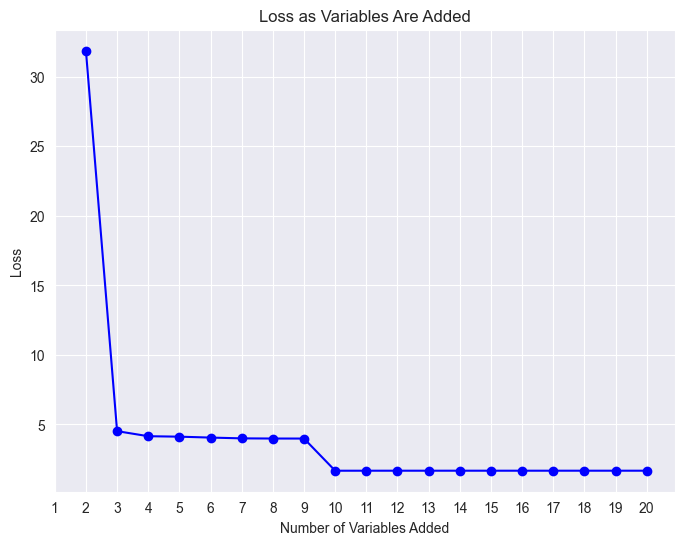

In [51]:
# -------------------------- plot the loss list --------------------------
plt.figure(figsize = (8, 6))
plt.plot(range(2, len(loss_list)), loss_list[2:], marker = 'o', linestyle = '-', color = 'b')
plt.title("Loss as Variables Are Added")
plt.xlabel("Number of Variables Added")
plt.ylabel("Loss")
plt.xticks(range(1, len(loss_list)))
plt.grid(True)
plt.show()

In [52]:
# -------------------------- select the model with the fewest variables --------------------------
# Find the minimum loss
min_loss = min(loss_list)
threshold = 2

# Find the smallest model with a loss within the threshold (min_loss + 0.01)
for i, loss in enumerate(loss_list):
    if loss <= min_loss + threshold:
        selected_model_index = i
        print(i)
        break  # Select the first such model with the fewest variables

# Get the selected variables
selected_variables = sorted_covariates[:i - 1] # minus 1 because the first loss is of the null model

# Return the list of loss values and the selected variables
selected_variables

10


['X5', 'X7', 'X8', 'X1', 'X3', 'X4', 'X2', 'X9', 'X6']

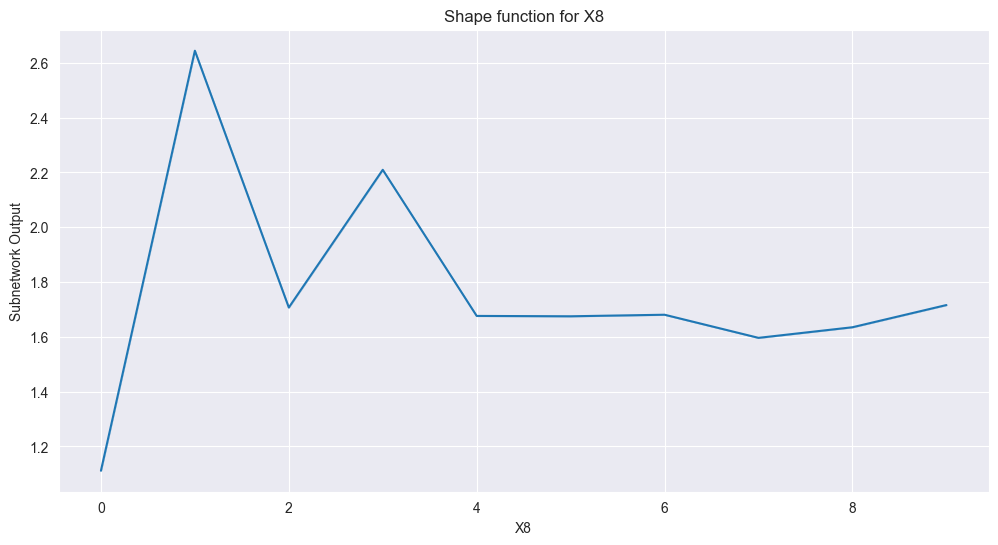

In [53]:
#-------------------------- view the shape function --------------------------
# create the plot
var_name = "X8"
var_index = all_vars.index(var_name)
plt.figure(figsize = (12, 6))
sns.lineplot(x = X_train_low_split[var_index], y = subnet_output_values[:,var_index].flatten()*subnet_weights[var_index][0])
plt.xlabel(f"{var_name}")
plt.ylabel('Subnetwork Output')
plt.title(f"Shape function for {var_name}")
plt.grid(True)
plt.show()

### GAMINet approach - High Variance

In [54]:
# -------------------------- create a NAM with main effects--------------------------

# model architecture
inputs = []  # Store input layers
sub_outputs = []  # Outputs from each subnet

# model hyperparameters
num_neurons = 50
num_layers = 5
activation = 'leaky_relu'

# main effect
for name in all_vars:

    input_layer = Input(shape = (1,), name = name)
    inputs.append(input_layer)

    if name in cat_vars: # numeric variables
        # categorical variables will be one-hot encoded
        embed_layer = Embedding(input_dim = dt_high_cleaned[name].nunique(), output_dim = 1, name = f"embed_{name}")(input_layer)
        embed_layer_reshape = Reshape(target_shape = (1,))(embed_layer)
        switcher_layer = Dense(1, use_bias = False,
                               kernel_initializer = Constant(1.0), 
                               trainable = False, 
                               name = f"{name}_switcher_layer")(embed_layer_reshape) # used for pruning later
        sub_outputs.append(switcher_layer)
    else:
        subnet = create_subnet(num_layers, num_neurons, activation, f"{name}_subnetwork")
        sub_output = subnet(input_layer)
        switcher_layer = Dense(1, use_bias = False, 
                               kernel_initializer = Constant(1.0), 
                               trainable = False, 
                               name = f"{name}_switcher_layer")(sub_output) # used for pruning later
        sub_outputs.append(switcher_layer)

# combine subnets' outputs
subnets = Concatenate(name = f"subnet_output")(sub_outputs + [])
output_layer = Dense(1, activation = 'exponential', 
                     kernel_initializer = Constant(1),
                     name = "final_output")(subnets)

# final model
model_GAMI_high = Model(inputs = inputs, outputs = output_layer)

In [55]:
# -------------------------- compile and train the model --------------------------
# create training & validation data consistent with the model architecture
X_train_high_split = []
X_val_high_split = []
for i in range(len(X_train_high .columns)):
    X_train_high_split.append(X_train_high .iloc[:, i])
    X_val_high_split.append(X_val_high .iloc[:, i])

# compile and fit
model_GAMI_high.compile(optimizer = "rmsprop", loss = gamma_log_likelihood, metrics = [RootMeanSquaredError()])
es = EarlyStopping(restore_best_weights = True, patience = 10)
%time hist_main = model_GAMI_high.fit(X_train_high_split, y_train_high, epochs = 5_000, \
    callbacks = [es], batch_size = 500, validation_data = (X_val_high_split, y_val_high))

Epoch 1/5000


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 3129.4189 - root_mean_squared_error: 26784.9141 - val_loss: 2108.2690 - val_root_mean_squared_error: 15868.2314
Epoch 2/5000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1978.9110 - root_mean_squared_error: 26784.5430 - val_loss: 1601.1935 - val_root_mean_squared_error: 15867.8662
Epoch 3/5000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1538.8286 - root_mean_squared_error: 26784.2383 - val_loss: 1257.6769 - val_root_mean_squared_error: 15867.5625
Epoch 4/5000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1206.4536 - root_mean_squared_error: 26784.0137 - val_loss: 983.7601 - val_root_mean_squared_error: 15867.2012
Epoch 5/5000
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 942.0377 - root_mean_squared_error: 26783.7207 - val_loss: 768.6589 - val_root_mean_squared_error: 15866.7676
Epoch 6/5000
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 731.9647 - root_mean_squared_error: 26783.3301 - val_loss: 594.8166 - val_root_mean_squared_e

358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


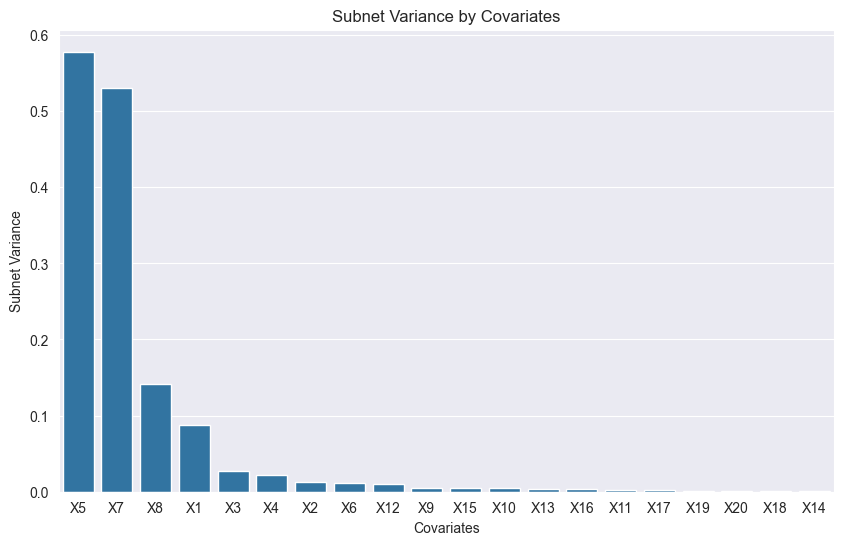

In [56]:
# -------------------------- quantify variable importance --------------------------
# Create a new model to get the output of the 'subnet_output' layer
subnet_output_layer = model_GAMI_high.get_layer("subnet_output")  # Get the subnet output layer
subnet_output_model = Model(inputs = model_GAMI_high.inputs, outputs = subnet_output_layer.output)
subnet_output_values = subnet_output_model.predict(X_train_high_split)
subnet_weights = model_GAMI_high.get_layer("final_output").get_weights()[0]

# Get the variance of each subnetwork across all data points
subnet_variance = []
for i in range(subnet_output_values.shape[1]):
    subnet_variance.append(np.var(subnet_output_values[:, i])*subnet_weights[i][0]**2)

# Define covariates
covariates = [name for name in all_vars]

# -------------------------- plot the variable importance --------------------------
# Create DataFrame for variable importance
var_importance = pd.DataFrame({"Covariates": covariates, "Subnet Variance": subnet_variance})

# Sort the DataFrame by subnet variance in decreasing order
varimp_sorted = var_importance.sort_values(by = "Subnet Variance", ascending = False)

# Create a bar plot using Seaborn
plt.figure(figsize = (10, 6))
sns.barplot(x = "Covariates", y = "Subnet Variance", data = varimp_sorted)
plt.title("Subnet Variance by Covariates")
plt.xlabel("Covariates")
plt.ylabel("Subnet Variance")
plt.show()

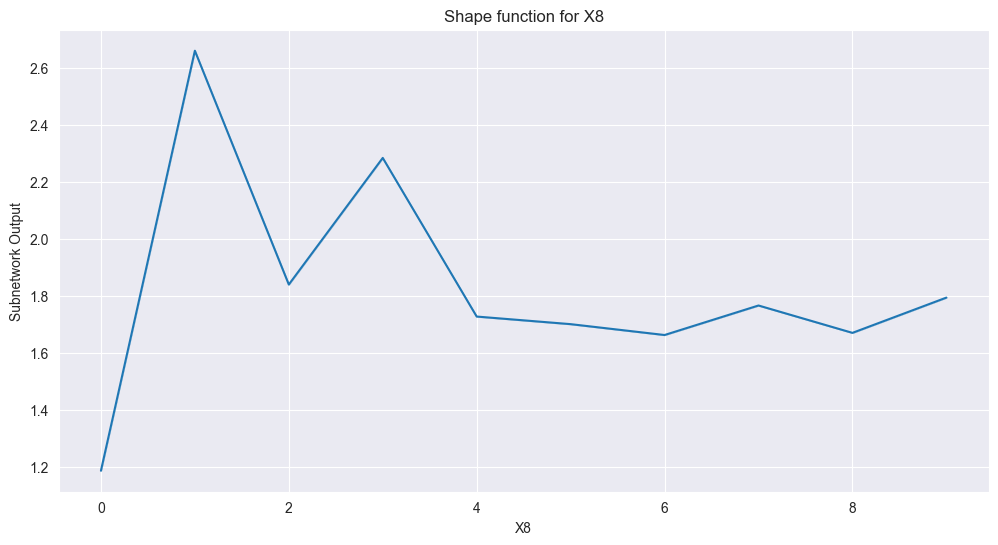

In [57]:
#-------------------------- view the shape function --------------------------
# create the plot
var_name = "X8"
var_index = all_vars.index(var_name)
plt.figure(figsize = (12, 6))
sns.lineplot(x = X_train_high_split[var_index], y = subnet_output_values[:,var_index].flatten()*subnet_weights[var_index][0])
plt.xlabel(f"{var_name}")
plt.ylabel('Subnetwork Output')
plt.title(f"Shape function for {var_name}")
plt.grid(True)
plt.show()

### Sparse NAM with LASSO

In [58]:
# -------------------------- create a NAM with main effects --------------------------
# For reproducibility
seed_value = 2024
keras.utils.set_random_seed(seed_value)

# Model architecture
inputs = []  # Store input layers
sub_outputs = []  # Outputs from each subnet

# Model hyperparameters
num_neurons = 40
num_layers = 5
activation = 'leaky_relu'

# Main effect
for name in all_vars:
    input_layer = Input(shape=(1,), name = name)
    inputs.append(input_layer)

    if name in cat_vars:  # Categorical variables
        # Categorical variables will be one-hot encoded
        embed_layer = Embedding(input_dim = dt_low_cleaned[name].nunique(), output_dim = 1, name = f"embed_{name}")(input_layer)
        embed_layer_reshape = Reshape(target_shape = (1,))(embed_layer)
        sub_outputs.append(embed_layer_reshape)
    else:  # Numeric variables
        subnet = create_subnet(num_layers, num_neurons, activation, f"{name}_subnetwork")
        sub_output = subnet(input_layer)
        sub_outputs.append(sub_output)

# Combine subnets' outputs
subnets = Concatenate(name = f"subnet_output")(sub_outputs)
output_layer = Dense(1, activation = 'exponential', 
                     kernel_regularizer = regularizers.l1(0.01))(subnets)  # LASSO regularization (l1)

# Final model
model_SNAM = Model(inputs = inputs, outputs = output_layer)

In [59]:
# -------------------------- fit the model --------------------------
# compile
model_SNAM.compile(optimizer = "adam", loss = gamma_log_likelihood, metrics = [RootMeanSquaredError()])
es = EarlyStopping(restore_best_weights = True, patience = 10)

# Train the model
model_SNAM.fit(X_train_low_split, y_train_low, epochs = 5_000, batch_size = 500, 
               callbacks = [es], validation_data = (X_val_low_split, y_val_low))

Epoch 1/5000


24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 2935.1262 - root_mean_squared_error: 7672.0454 - val_loss: 2501.2131 - val_root_mean_squared_error: 7707.8867
Epoch 2/5000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2332.1174 - root_mean_squared_error: 7671.8237 - val_loss: 2050.9702 - val_root_mean_squared_error: 7706.9741
Epoch 3/5000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1962.4254 - root_mean_squared_error: 7671.1909 - val_loss: 1786.3320 - val_root_mean_squared_error: 7707.0195
Epoch 4/5000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1706.5918 - root_mean_squared_error: 7671.0635 - val_loss: 1554.8958 - val_root_mean_squared_error: 7706.7964
Epoch 5/5000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1475.2253 - root_mean_squared_error: 7670.8491 - val_loss: 1327.1140 - val_root_mean_squared_error: 7706.5366
Epoch 6/5000
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1254.0145 - root_mean_squared_error: 7670.5420 - val_loss: 1117.8599 - val_root_mean_squared_error:

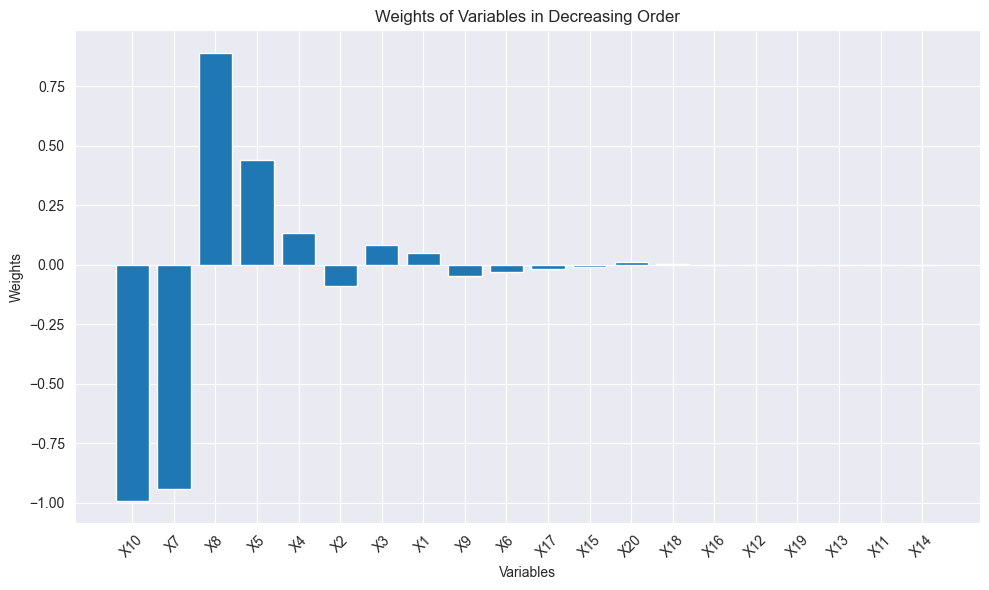

In [60]:
# -------------------------- get weights of the last layer --------------------------
last_layer_weights = model_SNAM.layers[-1].get_weights()[0]  # Extract weights from the last layer

# Combine variable names with corresponding weights
variable_weights = list(zip(all_vars, last_layer_weights.flatten()))  # Pair each variable with its corresponding weight

# Sort variables by their weights in decreasing order
sorted_weights = sorted(variable_weights, key = lambda x: abs(x[1]), reverse=True)

# Plotting the weights in decreasing order
variables, weight_values = zip(*sorted_weights)
plt.figure(figsize = (10, 6))
plt.bar(variables, weight_values)
plt.xlabel("Variables")
plt.ylabel("Weights")
plt.title("Weights of Variables in Decreasing Order")
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

371/371 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


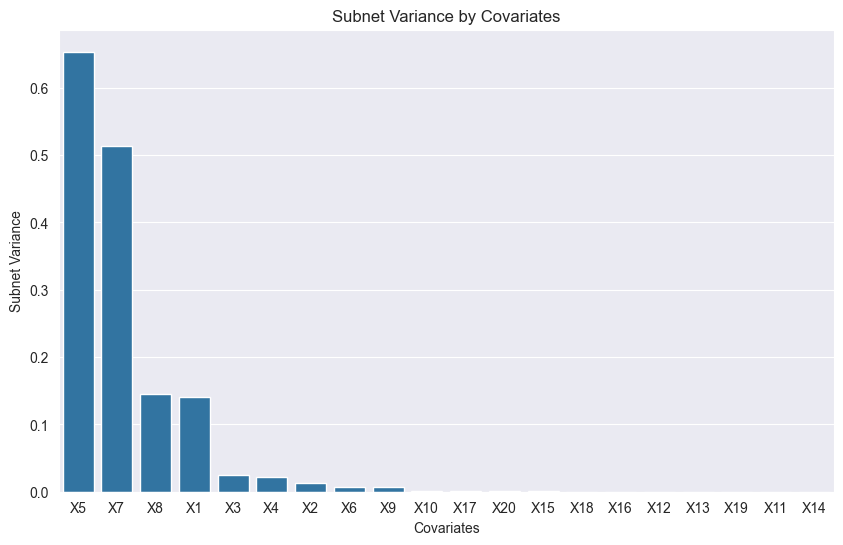

In [61]:
# -------------------------- quantify variable importance --------------------------
# Create a new model to get the output of the 'subnet_output' layer
subnet_output_layer = model_SNAM.get_layer("subnet_output")  # Get the subnet output layer
subnet_output_model = Model(inputs = model_SNAM.inputs, outputs = subnet_output_layer.output)
subnet_output_values = subnet_output_model.predict(X_train_low_split)

# Get the variance of each subnetwork across all data points
subnet_variance = []
for i in range(subnet_output_values.shape[1]):
    subnet_variance.append(np.var(subnet_output_values[:, i])*last_layer_weights[i][0]**2)

# Define covariates
covariates = [name for name in all_vars]

# -------------------------- plot the variable importance --------------------------
# Create DataFrame for variable importance
var_importance = pd.DataFrame({"Covariates": covariates, "Subnet Variance": subnet_variance})

# Sort the DataFrame by subnet variance in decreasing order
varimp_sorted = var_importance.sort_values(by = "Subnet Variance", ascending = False)

# Create a bar plot using Seaborn
plt.figure(figsize = (10, 6))
sns.barplot(x = "Covariates", y = "Subnet Variance", data = varimp_sorted)
plt.title("Subnet Variance by Covariates")
plt.xlabel("Covariates")
plt.ylabel("Subnet Variance")
plt.show()

371/371 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


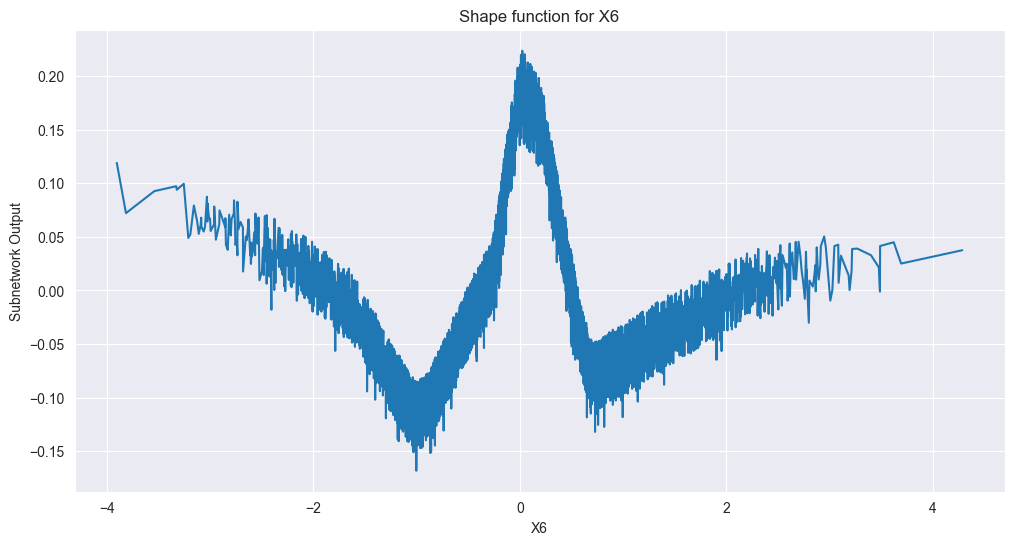

In [62]:
#-------------------------- view the shape function --------------------------
subnet_output_layer = model_SNAM.get_layer("subnet_output")  # Get the subnet output layer
subnet_output_model = Model(inputs = model_SNAM.inputs, outputs = subnet_output_layer.output)
subnet_output_values = subnet_output_model.predict(X_train_low_split)

# create the plot
var_name = "X6"
var_index = all_vars.index(var_name)
plt.figure(figsize = (12, 6))
sns.lineplot(x = X_train_low_split[var_index], 
             y = subnet_output_values[:,var_index].flatten()*last_layer_weights[var_index][0])
plt.xlabel(f"{var_name}")
plt.ylabel('Subnetwork Output')
plt.title(f"Shape function for {var_name}")
plt.grid(True)
plt.show()